## 1. Installing Dependencies

In [ ]:
!pip install facenet-pytorch mtcnn scikit-learn numpy pandas opencv-python-headless tqdm torch torchvision

## 2. Mounting Google Drive

In [2]:
# connect colab to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Setting up Project Folders

In [ ]:
import os
project_root = '/content/drive/MyDrive/FaceRecognitionProject'
dataset_root = os.path.join(project_root, 'dataset')
cropped_root = os.path.join(project_root, 'cropped_faces')
embeddings_root = os.path.join(project_root, 'embeddings')
model_root = os.path.join(project_root, 'model')

for path in [dataset_root, cropped_root, embeddings_root, model_root]:
    os.makedirs(path, exist_ok=True)

os.makedirs(os.path.join(dataset_root, 'Me'), exist_ok=True)
os.makedirs(os.path.join(dataset_root, 'Unknown'), exist_ok=True)

print("Project folder structure prepared.")

Project folder structure prepared.


## 4. Face Cropping and Data Augmentation

In [ ]:
import os
import numpy as np
from PIL import Image
from facenet_pytorch import MTCNN
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Folder paths
data_root = '/content/drive/My Drive/FaceRecognitionProject/dataset'
cropped_root = '/content/drive/My Drive/FaceRecognitionProject/cropped_faces'

# Load MTCNN model and assign to CPU
device = torch.device('cpu')
mtcnn = MTCNN(keep_all=True).to(device)
print(f"MTCNN model loaded to {device} device.")

# Define transformations for data augmentation
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

def gather_image_paths(data_root):
    paths = []
    labels = []
    for cls in ['Me', 'Unknown']:
        class_dir = os.path.join(data_root, cls)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png', '.bmp')):
                paths.append(os.path.join(class_dir, fname))
                labels.append(cls)
    return np.array(paths), np.array(labels)

# Gather original photo paths
all_paths, all_labels = gather_image_paths(data_root)

if len(all_paths) == 0:
    print("Error: No images found in the dataset folder. Please make sure you have added images.")
else:
    # Split original photos with identity-based split
    X_train_paths, X_test_paths, y_train_labels, y_test_labels = train_test_split(
        all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )

    # Create folders
    for split in ['train', 'test']:
        for cls in ['Me', 'Unknown']:
            os.makedirs(os.path.join(cropped_root, split, cls), exist_ok=True)

    def process_and_augment(image_paths, labels, split_dir):
        for i in tqdm(range(len(image_paths)), desc=f'Cropping faces and augmenting data ({split_dir})'):
            img_path = image_paths[i]
            label = labels[i]

            try:
                img = Image.open(img_path).convert('RGB')
                boxes, _ = mtcnn.detect(img)

                if boxes is not None and len(boxes) > 0:
                    box = boxes[0]
                    face = img.crop(box)

                    # Save the original cropped face
                    face.save(os.path.join(cropped_root, split_dir, label, f'original_{os.path.basename(img_path)}'))

                    # Apply data augmentation only to training data
                    if split_dir == 'train':
                        for j in range(5):  # 5 augmented versions per image
                            augmented_face = data_transforms(face)
                            augmented_face.save(os.path.join(cropped_root, split_dir, label, f'augmented_{j}_{os.path.basename(img_path)}'))
            except Exception as e:
                print(f"An error occurred: {img_path} - {e}")

    if __name__ == '__main__':
        print("Cropping faces and applying data augmentation for training...")
        process_and_augment(X_train_paths, y_train_labels, 'train')
        print("Cropping faces for testing...")
        process_and_augment(X_test_paths, y_test_labels, 'test')
        print("Face cropping and data augmentation completed. You can proceed to the next step.")

MTCNN model loaded to cpu device.
Cropping faces and applying data augmentation for training...


Cropping faces and augmenting data (train):   0%|          | 0/344 [00:00<?, ?it/s]

Cropping faces for testing...


Cropping faces and augmenting data (test):   0%|          | 0/86 [00:00<?, ?it/s]

Face cropping and data augmentation completed. You can proceed to the next step.


## 5. Generating Face Embeddings

In [ ]:
import os
import torch
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import joblib
import torchvision.transforms as transforms

# Folder paths
cropped_root = '/content/drive/My Drive/FaceRecognitionProject/cropped_faces'
embeddings_path = '/content/drive/My Drive/FaceRecognitionProject/embeddings'

os.makedirs(embeddings_path, exist_ok=True)

# Move FaceNet model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device used for training: {device}')
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def get_embeddings_and_labels(data_dir):
    embeddings = []
    labels = []
    for class_name in ['Me', 'Unknown']:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in tqdm(os.listdir(class_dir), desc=f'Generating embeddings for {os.path.basename(data_dir)}...'):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])(img).unsqueeze(0).to(device)

                with torch.no_grad():
                    embedding = resnet(img_tensor).detach().cpu().numpy().flatten()
                embeddings.append(embedding)
                labels.append(class_name)
            except Exception as e:
                print(f'Error: An issue occurred while processing {img_path}. - {e}')
    return np.array(embeddings), np.array(labels)

# Process training and test data
X_train_embeddings, y_train_labels = get_embeddings_and_labels(os.path.join(cropped_root, 'train'))
X_test_embeddings, y_test_labels = get_embeddings_and_labels(os.path.join(cropped_root, 'test'))

if len(X_train_embeddings) > 0 and len(X_test_embeddings) > 0:
    # Normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_embeddings)
    X_test_scaled = scaler.transform(X_test_embeddings)
    joblib.dump(scaler, os.path.join(embeddings_path, 'scaler.joblib'))

    # Save NumPy files
    np.save(os.path.join(embeddings_path, 'X_train.npy'), X_train_scaled)
    np.save(os.path.join(embeddings_path, 'y_train.npy'), y_train_labels)
    np.save(os.path.join(embeddings_path, 'X_test.npy'), X_test_scaled)
    np.save(os.path.join(embeddings_path, 'y_test.npy'), y_test_labels)

    print('All embeddings successfully generated and saved to Google Drive.')
else:
    print("Insufficient data found for training or testing. Please check the first step.")

## 6. Training and Evaluating KNN Classifier

In [ ]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

# Folder paths
project_root = '/content/drive/My Drive/FaceRecognitionProject'
embeddings_root = os.path.join(project_root, 'embeddings')
model_root = os.path.join(project_root, 'model')

# Load saved data
try:
    X_train = np.load(os.path.join(embeddings_root, 'X_train.npy'))
    y_train = np.load(os.path.join(embeddings_root, 'y_train.npy'))
    X_test = np.load(os.path.join(embeddings_root, 'X_test.npy'))
    y_test = np.load(os.path.join(embeddings_root, 'y_test.npy'))
except FileNotFoundError:
    print("Required .npy files not found. Please make sure you have run the previous steps.")
    exit()

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train)

# Save the model
joblib.dump(knn_classifier, os.path.join(model_root, 'knn_classifier.joblib'))
print("KNN classifier successfully trained and saved.")

# Make predictions on test data
y_pred = knn_classifier.predict(X_test)

# Measure performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Me', 'Unknown'])
class_report = classification_report(y_test, y_pred, target_names=['Me', 'Unknown'])

print(f"Model accuracy: {accuracy:.2%}\n")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

KNN classifier successfully trained and saved.
Model accuracy: 91.67%

Confusion Matrix:
 [[44  2]
 [ 5 33]]

Classification Report:
               precision    recall  f1-score   support

          Me       0.90      0.96      0.93        46
     Unknown       0.94      0.87      0.90        38

    accuracy                           0.92        84
   macro avg       0.92      0.91      0.92        84
weighted avg       0.92      0.92      0.92        84



## 7. Live Face Recognition

Checking required libraries...
Libraries successfully loaded.

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive connection successful.
Device used for training and inference: cpu
FaceNet and MTCNN models successfully loaded.
Attempting to load classifier and scaler...
Classifier and scaler successfully loaded.

Starting live face recognition...
Camera is opening, please press the "Capture Image" button.


<IPython.core.display.Javascript object>

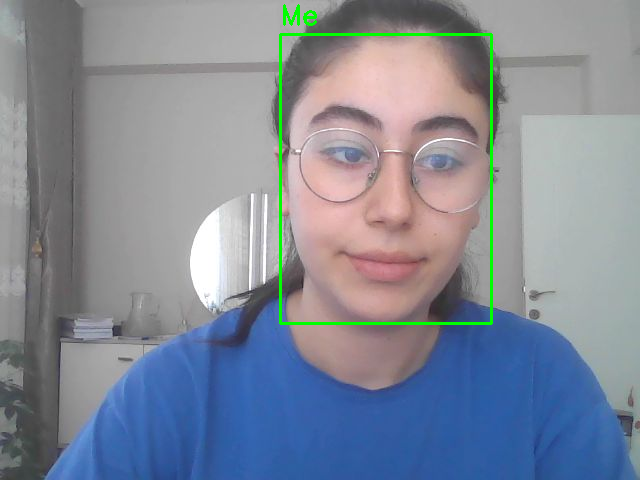

Predictions: ['Me']

Live recognition process finished (either completed or loading failed).


In [5]:
import os
import numpy as np
import joblib
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms

print("Checking required libraries...")
try:
    import facenet_pytorch
    import mtcnn
    import joblib
    import cv2
    import PIL
    import torch
    import torchvision
    print("Libraries successfully loaded.")
except ImportError as e:
    print(f"Error: Some required libraries are missing. Please run the 'Step 1: Installing Dependencies' cell again. Details: {e}")
    pass # Allow code to continue to show other potential issues

# Mount Google Drive (if session was reset)
print("\nConnecting to Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive connection successful.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()


# --- LOAD DEVICE AND MODELS ---
device = torch.device('cpu')
print(f'Device used for training and inference: {device}')

try:
    # Load MTCNN and FaceNet models to CPU
    mtcnn = MTCNN(keep_all=True).to(device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    print("FaceNet and MTCNN models successfully loaded.")
except Exception as e:
    print(f"Error loading FaceNet or MTCNN models: {e}")
    exit()


# --- LOAD TRAINED MODELS ---
project_root = '/content/drive/My Drive/FaceRecognitionProject'
model_path = os.path.join(project_root, 'model', 'knn_classifier.joblib')
scaler_path = os.path.join(project_root, 'embeddings', 'scaler.joblib')

def recognize_live_face(knn_classifier_model, scaler_model, mtcnn_detector, resnet_model, device_used):
    """
    Performs face recognition from live webcam feed using loaded models.
    """
    try:
        print('Camera is opening, please press the "Capture Image" button.')
        filename = take_photo()

        # Read image with OpenCV
        img = cv2.imread(filename)
        if img is None:
             print("Error: Could not read image file.")
             return 'Image Read Error'

        # Convert to PIL format
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Face detection
        boxes, _ = mtcnn_detector.detect(img_pil)

        if boxes is None or len(boxes) == 0:
            print('No face found in the image.')
            return 'No Face Detected'

        # Process all detected faces
        predictions = []
        for box in boxes:
            try:
                box = box.astype(int)
                # Ensure box coordinates are within image bounds
                box = [max(0, box[0]), max(0, box[1]), min(img_pil.width, box[2]), min(img_pil.height, box[3])]

                face_img = img_pil.crop(box)

                # Resize face to expected input size for FaceNet
                face_img = face_img.resize((160, 160))

                # Convert cropped face to tensor and normalize
                face_tensor = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # VGGFace2 normalization
                ])(face_img).unsqueeze(0).to(device_used)


                # Extract embedding with FaceNet
                with torch.no_grad():
                    embedding = resnet_model(face_tensor).detach().cpu().numpy().reshape(1, -1)

                # Normalize with trained scaler
                # Must be normalized in the same way as the data the model was trained on.
                scaled_embedding = scaler_model.transform(embedding)

                # Make prediction with KNN model
                prediction = knn_classifier_model.predict(scaled_embedding)
                predictions.append(prediction[0])

                # Draw prediction result and box on the image
                # Choose a color based on prediction
                color = (0, 255, 0) if prediction[0] == 'Me' else (0, 0, 255) # Green for Me, Red for Unknown
                cv2.putText(img, prediction[0], (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)

            except Exception as e:
                print(f"Error processing a detected face: {e}")
                predictions.append('Processing Error')
                pass

        cv2_imshow(img)
        print(f'Predictions: {predictions}')
        return predictions

    except Exception as e:
        print(f'An overall error occurred during live face recognition: {e}')
        return ['Overall Error']

# Javascript function to capture image from camera (kept as is)
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Image';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            return new Promise((resolve) => {
                capture.onclick = () => {
                    const canvas = document.createElement('canvas');
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    stream.getVideoTracks()[0].stop();
                    div.remove();
                    resolve(canvas.toDataURL('image/jpeg', quality));
                };
            });
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


# -- CALL THE RECOGNITION FUNCTION ONLY IF MODELS ARE LOADED --
try:
    print('Attempting to load classifier and scaler...')
    knn_classifier = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    print('Classifier and scaler successfully loaded.')

    # If loading is successful, proceed with live recognition
    print("\nStarting live face recognition...")
    recognize_live_face(knn_classifier, scaler, mtcnn, resnet, device)

except FileNotFoundError:
    print(f'\nError: Classifier or scaler file not found. Please ensure you have completed the model training steps ({model_path}, {scaler_path}).')
except Exception as e:
    print(f'\nError loading classifier or scaler: {e}')

print("\nLive recognition process finished (either completed or loading failed).")

Checking required libraries...
Libraries successfully loaded.

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive connection successful.
Device used for training and inference: cpu
FaceNet and MTCNN models successfully loaded.
Attempting to load classifier and scaler...
Classifier and scaler successfully loaded.

Starting live face recognition...
Camera is opening, please press the "Capture Image" button.


<IPython.core.display.Javascript object>

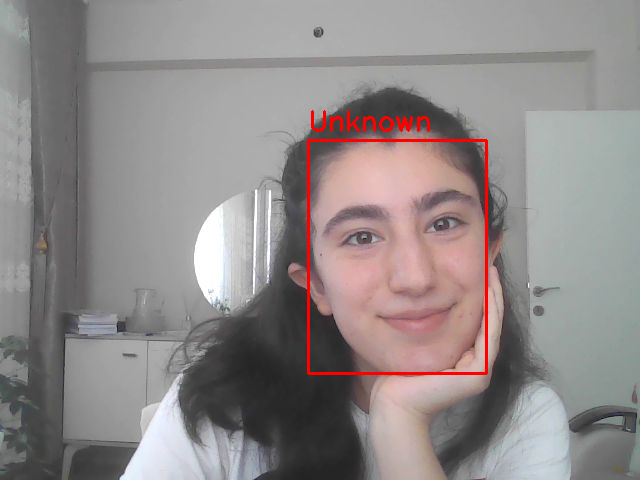

Predictions: ['Unknown']

Live recognition process finished (either completed or loading failed).


In [6]:
import os
import numpy as np
import joblib
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms

print("Checking required libraries...")
try:
    import facenet_pytorch
    import mtcnn
    import joblib
    import cv2
    import PIL
    import torch
    import torchvision
    print("Libraries successfully loaded.")
except ImportError as e:
    print(f"Error: Some required libraries are missing. Please run the 'Step 1: Installing Dependencies' cell again. Details: {e}")
    pass # Allow code to continue to show other potential issues

# Mount Google Drive (if session was reset)
print("\nConnecting to Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive connection successful.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    exit()


# --- LOAD DEVICE AND MODELS ---
device = torch.device('cpu')
print(f'Device used for training and inference: {device}')

try:
    # Load MTCNN and FaceNet models to CPU
    mtcnn = MTCNN(keep_all=True).to(device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    print("FaceNet and MTCNN models successfully loaded.")
except Exception as e:
    print(f"Error loading FaceNet or MTCNN models: {e}")
    exit()


# --- LOAD TRAINED MODELS ---
project_root = '/content/drive/My Drive/FaceRecognitionProject'
model_path = os.path.join(project_root, 'model', 'knn_classifier.joblib')
scaler_path = os.path.join(project_root, 'embeddings', 'scaler.joblib')

def recognize_live_face(knn_classifier_model, scaler_model, mtcnn_detector, resnet_model, device_used):
    """
    Performs face recognition from live webcam feed using loaded models.
    """
    try:
        print('Camera is opening, please press the "Capture Image" button.')
        filename = take_photo()

        # Read image with OpenCV
        img = cv2.imread(filename)
        if img is None:
             print("Error: Could not read image file.")
             return 'Image Read Error'

        # Convert to PIL format
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Face detection
        boxes, _ = mtcnn_detector.detect(img_pil)

        if boxes is None or len(boxes) == 0:
            print('No face found in the image.')
            return 'No Face Detected'

        # Process all detected faces
        predictions = []
        for box in boxes:
            try:
                box = box.astype(int)
                # Ensure box coordinates are within image bounds
                box = [max(0, box[0]), max(0, box[1]), min(img_pil.width, box[2]), min(img_pil.height, box[3])]

                face_img = img_pil.crop(box)

                # Resize face to expected input size for FaceNet
                face_img = face_img.resize((160, 160))

                # Convert cropped face to tensor and normalize
                face_tensor = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # VGGFace2 normalization
                ])(face_img).unsqueeze(0).to(device_used)


                # Extract embedding with FaceNet
                with torch.no_grad():
                    embedding = resnet_model(face_tensor).detach().cpu().numpy().reshape(1, -1)

                # Normalize with trained scaler
                # Must be normalized in the same way as the data the model was trained on.
                scaled_embedding = scaler_model.transform(embedding)

                # Make prediction with KNN model
                prediction = knn_classifier_model.predict(scaled_embedding)
                predictions.append(prediction[0])

                # Draw prediction result and box on the image
                # Choose a color based on prediction
                color = (0, 255, 0) if prediction[0] == 'Me' else (0, 0, 255) # Green for Me, Red for Unknown
                cv2.putText(img, prediction[0], (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)

            except Exception as e:
                print(f"Error processing a detected face: {e}")
                predictions.append('Processing Error')
                pass

        cv2_imshow(img)
        print(f'Predictions: {predictions}')
        return predictions

    except Exception as e:
        print(f'An overall error occurred during live face recognition: {e}')
        return ['Overall Error']

# Javascript function to capture image from camera (kept as is)
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Image';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            return new Promise((resolve) => {
                capture.onclick = () => {
                    const canvas = document.createElement('canvas');
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    stream.getVideoTracks()[0].stop();
                    div.remove();
                    resolve(canvas.toDataURL('image/jpeg', quality));
                };
            });
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


# -- CALL THE RECOGNITION FUNCTION ONLY IF MODELS ARE LOADED --
try:
    print('Attempting to load classifier and scaler...')
    knn_classifier = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    print('Classifier and scaler successfully loaded.')

    # If loading is successful, proceed with live recognition
    print("\nStarting live face recognition...")
    recognize_live_face(knn_classifier, scaler, mtcnn, resnet, device)

except FileNotFoundError:
    print(f'\nError: Classifier or scaler file not found. Please ensure you have completed the model training steps ({model_path}, {scaler_path}).')
except Exception as e:
    print(f'\nError loading classifier or scaler: {e}')

print("\nLive recognition process finished (either completed or loading failed).")